<h1 style="text-align: center;">REPLICATION NOTEBOOK: <br>
Do ESG factors relate to yields of companies?</h1>

In [2]:
# Import / install relevant Python packages
import pandas as pd
import requests
import yfinance as yf
import os
from io import StringIO
from datetime import datetime
from dateutil.relativedelta import relativedelta

## 1 Fetching raw data
Fetch data for Fama-Frech factores, ESG scores, and prices of NASDAQ 100 constituents

In [3]:
# Define start and end data for data you want to fetch
# The timeseries will start the first of the month after the specified month. E.g. for 2014-08-01, the first data point will bi on 2014-09-01
# Note: after the return calculation the first row will be useless. E.g. we choose 2014-08-01 that our data then starts on 2014-10-01
start_date = '2014-08-01'
end_date = '2022-08-01'

# Fetch constituents of Nasdaq 100 from wikipedia
# If other Index is needed, exchange the link and the index of the table, e.g. for the S&P 500 use 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0] 
# and if name of column holding the tickers changed, must be updated in line 17 e.g. symbol for S&P 500
constituents = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]

# Create list from tickers
tickers = constituents.Ticker.to_list()

Utility functions used for fetching data from the three sources.

In [4]:
# Fetch csv file for Fama French factors from official website
def fetch_fama_french():

    # URL of the CSV file
    csv_url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors.CSV"
    
    # Send a GET request to the URL
    response = requests.get(csv_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Read CSV starting from row 4 until row 1154
        df = pd.read_csv(StringIO(response.text), skiprows=3, nrows=1154)

        # Convert the 'Date' column to pandas datetime format
        df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], format='%Y%m')

        # Convert the start_date string to a datetime object, add to month for reasons specified under the definition of the start date
        start_date_object = datetime.strptime(start_date, "%Y-%m-%d") + relativedelta(months=2)

        # Format the datetime object to the desired format
        formatted_start_date = start_date_object.strftime("%Y%m") 

        # Specify the cutoff date
        cutoff_date = pd.to_datetime(formatted_start_date, format='%Y%m')

        # Filter rows based on the condition
        df = df[df['Unnamed: 0'] >= cutoff_date]

        return df
    else:
        return f"Failed to retrieve the file. Status code: {response.status_code}"
    
# Fetch montly returns for specific index
def fetch_monthly_returns(start_date, end_date, tickers):

    try:
        # Fetch the stock prices for this tickers from yahoo finance
        prices = yf.download(tickers,start_date,end_date, auto_adjust=True)['Close']

        # Convert index to datetime so that 'resample' can be used
        prices.index = pd.to_datetime(prices.index)

        # Calculate the monthly returns
        monthly_returns = prices.resample('M').ffill().pct_change()

        # Drop first row as it is NA from return calculation
        monthly_returns = monthly_returns.iloc[1:]

    except ValueError:
        print('Failed download, try again.')
        prices = None
    
    return monthly_returns

# Downloads historic ESG ratings for a list of tickers and returns it as a single DataFrame
def fetch_esg(tickers):

    # Create dataframe to store data
    combined_esg_data = pd.DataFrame()
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) '
                             'Chrome/50.0.2661.102 Safari/537.36'}

    # Iterate over all tickers and send GET request
    for ticker in tickers:
        response = requests.get('https://query2.finance.yahoo.com/v1/finance/esgChart', params={"symbol": tickers},
                                headers=headers)

        # Create Dataframe from fetched data
        try:
            df = pd.DataFrame(response.json()["esgChart"]["result"][0]["symbolSeries"])
            df["Date"] = pd.to_datetime(df["timestamp"], unit="s")

            df = df.rename(columns={"esgScore": f"{ticker}_Total_Score",
                                    "environmentScore": f"{ticker}_E_Score",
                                    "socialScore": f"{ticker}_S_Score",
                                    "governanceScore": f"{ticker}_G_Score"})

            # Remove timestamp column
            df = df[['Date', f"{ticker}_Total_Score", f"{ticker}_E_Score", f"{ticker}_S_Score", f"{ticker}_G_Score"]]

            # Merge data for each ticker
            if combined_esg_data.empty:
                combined_esg_data = df
            else:
                combined_esg_data = pd.merge(combined_esg_data, df, on='Date', how='outer')

        except:
            print(f'An error has occurred for {ticker}. The ticker symbol might be wrong or you might need to wait to continue.')

    return combined_esg_data


Save fetched data to csv files. The same files are later imported in the analysis notebook. Although redundant in this notebook, saving to csv, and later building LiteSQL database, is repeated in the notebooks for the sake of reproducibility of the source code.

In [5]:
# Specify the folder path
folder_path = '../data/raw/'

# Create the full path by joining the folder path and file name
output_path_mr = f'{folder_path}monthly_returns.csv'
output_path_esg = f'{folder_path}esg_data.csv'
output_path_ff = f'{folder_path}F-F_Research_Data_Factors.csv'

# Fetch data and save to folder data raw
fetch_monthly_returns(start_date,end_date,tickers).to_csv(output_path_mr, index=True)
fetch_esg(tickers).to_csv(output_path_esg, index=True)
fetch_fama_french().to_csv(output_path_ff, index=True)

[*********************100%%**********************]  101 of 101 completed


1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1406865600, endDate = 1659326400")


## 2 Exploratory Data Analysis & Preprocessing

### 2.1 ESG scores

In [3]:
# Import ESG data
esgdata =  pd.read_csv(r'../data/raw/esg_data.csv', index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])

<AxesSubplot: xlabel='Date'>

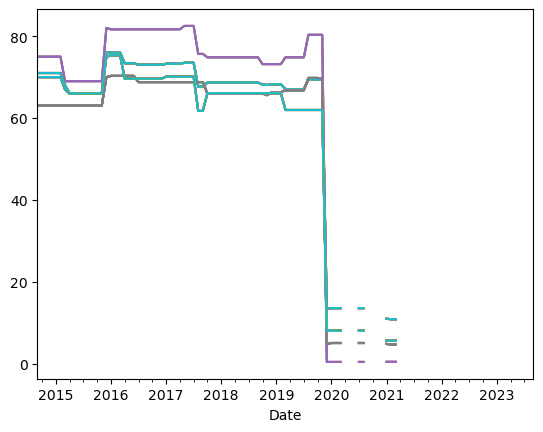

In [4]:
(esgdata
 .sample(n=30,axis='columns',replace=False, random_state=1)
 .plot(legend=None))

Seems that the ESG scores are not consistently after November 2019. This is because the data provider changed the methodology of calculating the scores. We will use the scores from the old methodology, as we want to have a consistent time series.

<AxesSubplot: xlabel='Date'>

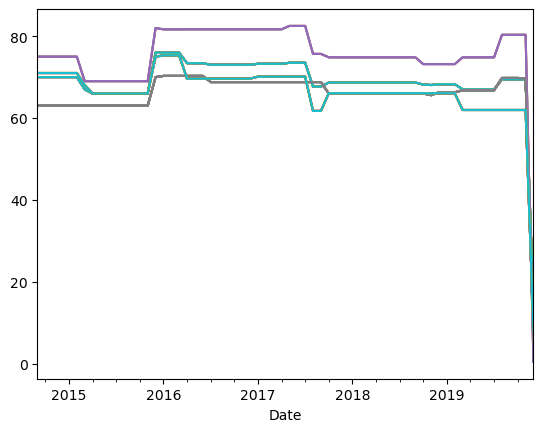

In [5]:
(esgdata
 .sample(n=30,axis='columns',replace=False, random_state=1)
 .loc[:'2019-12-01']
 .plot(legend=None))

#### 2.1.1 Imputation of missing values in ESG scores: **Forward Fill vs. Mean Fill**

<AxesSubplot: xlabel='Date'>

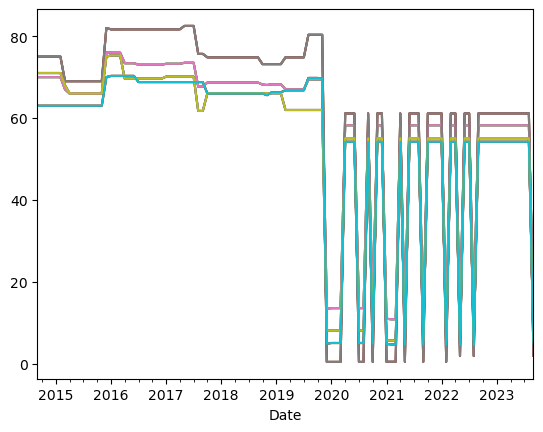

In [6]:
esgdata_mean_inputed = esgdata.fillna(esgdata.mean())
esgdata_mean_inputed.iloc[:, 0:20].plot(legend=None)

<AxesSubplot: xlabel='Date'>

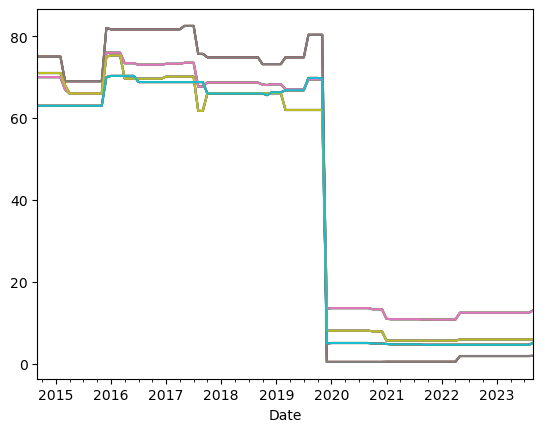

In [7]:
esgdata_ff_inputed = esgdata.fillna(method='ffill')
esgdata_ff_inputed.iloc[:, 0:20].plot(legend=None)

We can see that imputation of missing values with mean fill is not a good idea, as it introduces a lot of noise. We will use forward fill instead.

In [8]:
esgdata = esgdata_ff_inputed

### 2.2 Fama-French factors

In [9]:
# Import Fama-Frech data (does not need any processing)
famafrenchdata =  pd.read_csv(r'../data/raw/F-F_Research_Data_Factors.csv', index_col=1)
famafrenchdata.index = pd.to_datetime(famafrenchdata.index, format='%Y-%m-%d').rename('Date')
famafrenchdata = famafrenchdata.iloc[:, 1:]
famafrenchdata

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-10-01,2.52,4.20,-1.81,0.00
2014-11-01,2.55,-2.06,-3.09,0.00
2014-12-01,-0.06,2.49,2.27,0.00
2015-01-01,-3.11,-0.55,-3.58,0.00
2015-02-01,6.13,0.61,-1.86,0.00
...,...,...,...,...
2022-04-01,-9.46,-1.41,6.19,0.01
2022-05-01,-0.34,-1.85,8.41,0.03
2022-06-01,-8.43,2.09,-5.97,0.06


<AxesSubplot: xlabel='Date'>

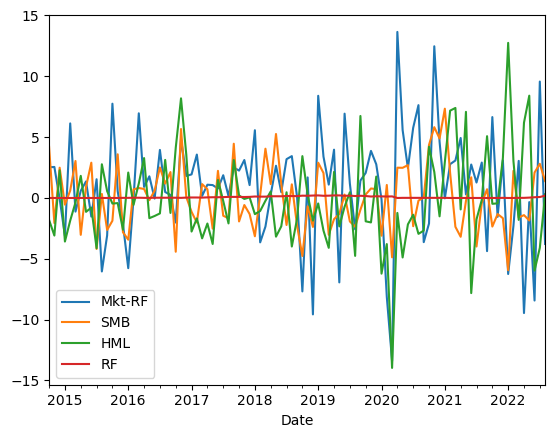

In [10]:
famafrenchdata.plot()

### 2.3 Monthly returns of NASDAQ 100 constituents

In [11]:
# This script cleans the data that it can be used in the regression

# Drop columns with all missing values
def drop_columns_with_missing_values(df):
    cols_before = df.columns
    df = df.dropna(axis=1, how='all')
    cols_after = df.columns
    dropped_cols = set(cols_before) - set(cols_after)
    print(f"Columns dropped due to all missing values: {dropped_cols}")

    return df

In [12]:
# Import monthly returns
monthlyreturns = pd.read_csv(r'../data/raw/monthly_returns.csv', index_col=0, parse_dates=True)
# Drop column with all NA
monthlyreturns = drop_columns_with_missing_values(monthlyreturns)

Columns dropped due to all missing values: {'GEHC'}


In [13]:
# Fill missing values using forward fill
monthlyreturns_ff_inputed = monthlyreturns.fillna(method='ffill')

<AxesSubplot: xlabel='Date'>

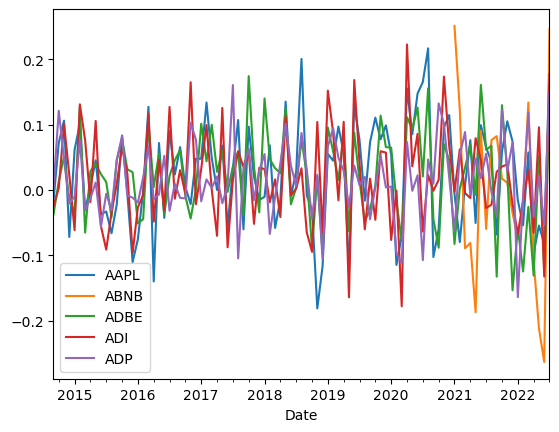

In [14]:
monthlyreturns_ff_inputed.iloc[:,0:5].plot()

In [15]:
monthlyreturns = monthlyreturns_ff_inputed

Since ESG data and Fama-French factors data are indexed by data which are the first day of the month, we will also index the monthly returns by the first day of the month. Currently, the monthly returns are indexed by the last day of the month. It is sufficient to shift the index by one day.

In [16]:
monthlyreturns.index = monthlyreturns.index.shift(1, freq='D')
monthlyreturns

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,TTD,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,-0.017073,NaN,-0.037691,-0.024757,0.000955,0.027218,-0.027747,-0.051047,-0.064907,-0.182254,...,NaN,-0.010170,-0.051410,0.200278,-0.020654,-0.135407,-0.094103,-0.042312,NaN,NaN
2014-11-01,0.071960,NaN,0.013441,0.002627,0.121177,0.044283,0.117410,0.018189,0.022212,-0.178886,...,NaN,0.048660,0.023978,0.002938,0.083516,-0.064815,0.157333,0.100987,NaN,NaN
2014-12-01,0.105979,NaN,0.050770,0.101169,0.047200,0.077511,-0.004711,0.081338,0.093592,-0.003571,...,NaN,0.095852,-0.005934,0.046520,0.073740,-0.012730,-0.088291,0.014042,NaN,NaN
2015-01-01,-0.071891,NaN,-0.013301,0.022961,-0.020879,-0.031290,0.055083,-0.017399,0.036175,-0.043011,...,NaN,-0.017456,0.033398,0.007805,0.110625,-0.012894,-0.062493,0.067320,NaN,NaN
2015-02-01,0.061424,NaN,-0.035351,-0.061419,-0.010076,-0.100733,0.034420,-0.051154,-0.083467,-0.037453,...,NaN,0.005863,0.004684,-0.072896,-0.032153,-0.158491,-0.026345,0.044822,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,0.057473,0.133804,-0.025787,0.030507,0.118539,-0.026699,0.100607,-0.147538,-0.017884,-0.113507,...,-0.188350,0.079358,0.212338,0.134554,-0.028640,-0.111586,0.045449,0.079370,-0.115913,0.008907
2022-05-01,-0.097131,-0.107999,-0.130964,-0.065383,-0.041136,-0.116958,-0.006615,-0.335069,-0.162747,-0.217853,...,-0.149170,-0.072106,-0.049294,0.046940,-0.052937,-0.271669,-0.136808,0.015103,-0.150644,-0.159731
2022-06-01,-0.054496,-0.211083,0.051850,0.095893,0.021817,0.097580,0.037584,-0.042323,0.065490,0.191066,...,-0.116599,0.045297,-0.142759,-0.016726,0.045869,0.016529,-0.243832,0.028392,0.079140,-0.244895


## 3 Save preprocessed data to csv

In [22]:
# Specify the folder path
folder_path = '../data/processed/'

# Create the full path by joining the folder path and file name
output_path_mr = f'{folder_path}monthly_returns_processed.csv'
output_path_esg = f'{folder_path}esg_data_processed.csv'
output_path_ff = f'{folder_path}fama_french_data_processed.csv'

# Save to data processed folder
monthlyreturns.to_csv(output_path_mr, index=True)
esgdata.to_csv(output_path_esg, index=True)
famafrenchdata.to_csv(output_path_ff, index=True)

## 4 Build SQLite database

In [17]:
import pandas as pd
from sqlalchemy import create_engine, Float, Date

# Read CSV files into pandas DataFrames
# Ensure dates are parsed correctly
esg_df = pd.read_csv('../data/processed/esg_data_processed.csv', index_col=0, parse_dates=True)
fama_french_df = pd.read_csv('../data/processed/fama_french_data_processed.csv', index_col=0, parse_dates=True )
monthly_returns_df = pd.read_csv('../data/processed/monthly_returns_processed.csv', index_col=0, parse_dates=True)

In [18]:
# Preparing column data types for SQL
esg_sql_types = {col: Float for col in esg_df.columns}
monthly_returns_sql_types = {col: Float for col in monthly_returns_df.columns}
fama_french_sql_types = {col: Float for col in esg_df.columns}

In [19]:
# Create an SQLAlchemy engine
engine = create_engine('sqlite:///../data/financial_data.db')

# Write the DataFrames to tables in the database
esg_df.to_sql('esg_data', engine, if_exists='replace', dtype=esg_sql_types, index=True)
fama_french_df.to_sql('fama_french_data', engine, if_exists='replace', dtype=fama_french_sql_types, index=True)
monthly_returns_df.to_sql('monthly_returns', engine, if_exists='replace', dtype=monthly_returns_sql_types, index=True)

95

## 5 Fit Factor Models

In [26]:
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
regressor = LinearRegression() # Creates a LinearRegression Object

In [27]:
# Create an SQLAlchemy engine
engine = create_engine('sqlite:///../data/financial_data.db')

# SQL queries to select all data from each table
esg_query = "SELECT * FROM esg_data"
monthly_returns_query = "SELECT * FROM monthly_returns"
fama_french_query = "SELECT * FROM fama_french_data"

# Read the data into pandas DataFrames
esgdata = pd.read_sql(esg_query, engine).set_index('Date')
monthlyreturns = pd.read_sql(monthly_returns_query, engine).set_index('Date')
fama_french = pd.read_sql(fama_french_query, engine).set_index('Date')

# Convert index to datetime
esgdata.index = pd.to_datetime(esgdata.index, format='%Y-%m-%d')
monthlyreturns.index = pd.to_datetime(monthlyreturns.index, format='%Y-%m-%d')
fama_french.index = pd.to_datetime(fama_french.index, format='%Y-%m-%d')


In [28]:
# Regression using loop
x = esgdata[['ADBE_E_Score']]

intercepts = [] # Initialize lists to store intercepts and coefficients
coefficients = []

# Loop over each column in 'monthlyreturns'
for column in monthlyreturns.columns:

    y = monthlyreturns[column]

    temp_df = x.join(y).dropna()

    x_temp = temp_df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
    y_temp = temp_df.iloc[:, 1].values.reshape(-1, 1)  

    # Fit the model
    regressor.fit(x_temp, y_temp)
    # Append the intercept and coefficients to the respective lists
    intercepts.append(regressor.intercept_)
    coefficients.append(regressor.coef_)

# Coefficients are stored in list of numpy arrays, converting to list of lists for readability
coefficients = [list(coef) for coef in coefficients]
intercepts = [list(intercepts) for intercept in intercepts]



In [29]:
# Calculate averages
avg_coef = np.mean(coefficients)
avg_int = np.mean(intercepts)
print(avg_coef)
print(avg_int)

-0.0029414927665507356
0.02468227478182373


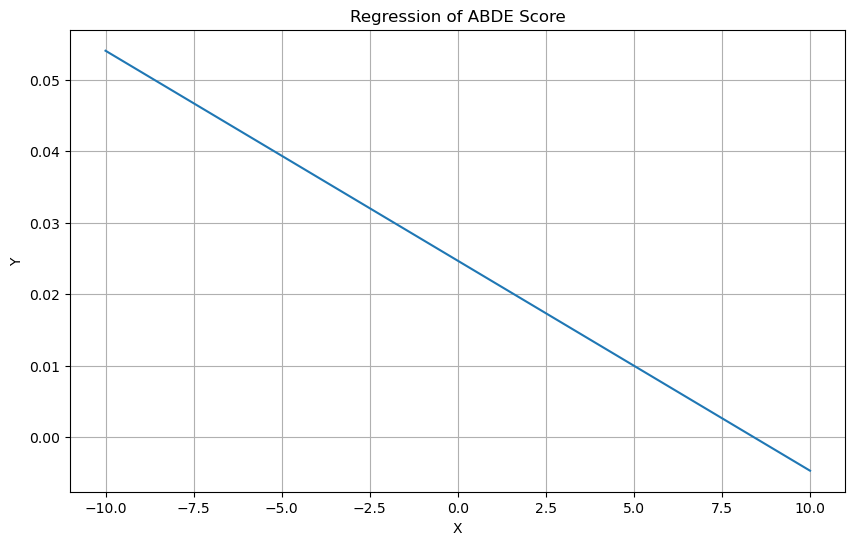

In [30]:
# Plot
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 400)
y = avg_coef * x + avg_int

plt.figure(figsize=(10,6))
plt.plot(x, y)
plt.title('Regression of ABDE Score')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
# plt.savefig('regression.png') # uncomment to save figure
plt.show()